# Boeing boeing: Dance Motion Detectionn #

## CNN version 0.2 Date: 2021.9.23 (Windows Version) ##

In [2]:
import os

import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## Load Dateset ##

In [3]:
data_path = os.path.join(os.getcwd(), 'data')
print(data_path)
print(os.listdir(data_path))

C:\Users\sanat\Documents\Github_\CG4002_Capstone\ML\cnn\data
['dws_1', 'dws_11', 'dws_2', 'jog_16', 'jog_9', 'sit_13', 'sit_5', 'std_14', 'std_6', 'ups_12', 'ups_3', 'ups_4', 'wlk_15', 'wlk_7', 'wlk_8']


In [4]:
# Load the whole data into a big dataset, this is for data/feature study prupose
folders = glob(os.path.join(data_path,'*_*'))
folders = [s for s in folders if ("csv" not in s) or (".DS_Store" not in s) or (".ipynb" not in s)]
df_all_list = []
activity_codes = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
activity_types = list(activity_codes.keys())

print(folders)

for j in folders:
    #print('j',j)
    csv_list = glob(j + '\\*')
    for i in csv_list:
        label = j.split('\\')[-1].split('_')[0]
#         print(label)
        if activity_codes.get(label) == None:
#             sys.exit(0)
            continue
        df = pd.read_csv(i)
        df['activity'] = activity_codes[label]
        df['sub_num'] = i[len(j)+5:-4]
        expnum = np.zeros(df.shape[0])
        df_all_list.append(df)
# print(df_all_list)
df_all = pd.concat(df_all_list,axis=0)
df_all = df_all.drop('Unnamed: 0',axis=1)
print(df_all.shape)
print(df_all.columns)
print(df.head(5))

['C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\dws_1', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\dws_11', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\dws_2', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\jog_16', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\jog_9', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\sit_13', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\sit_5', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\std_14', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\std_6', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\ups_12', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\ups_3', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_Capstone\\ML\\cnn\\data\\ups_4', 'C:\\Users\\sanat\\Documents\\Github_\\CG4002_

## Feature extraction ##

Each sample will be divided into 180 windows, inside each window we calculate min max mean std mad in time domain
We will get a 180 * 30 'image'
We should get 360 such samples

In [5]:
win_count = 180
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '\\*')
    label = j.split('\\')[-1].split('_')[0]
    for i in csv_list:
        df = pd.read_csv(i, usecols = ['gravity.x','gravity.y', 'gravity.z','userAcceleration.x','userAcceleration.y','userAcceleration.z'])
        segment_size = int(df.shape[0]/win_count)
        data_x = np.zeros((1, win_count, df.shape[1] * 5))
        data_y = np.zeros(1)
        for c in range(win_count):
            start_idx = c * segment_size
            end_idx = start_idx + segment_size
            temp_list = []
            means = df[start_idx:end_idx].mean().to_numpy()
            stds = df[start_idx:end_idx].mean().to_numpy()
            mins = df[start_idx:end_idx].min().to_numpy()
            maxs = df[start_idx:end_idx].max().to_numpy()
            mads = df[start_idx:end_idx].mad().to_numpy()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
            temp_list = np.concatenate(temp_list, axis = 0)
            data_x[0][c] = temp_list
            data_y[0] = activity_codes[label]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(360, 180, 30)
(360,)


## Train ##

In [6]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

259 72 29


In [7]:
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=6), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=6), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=6), dtype=tf.float32)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [10]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(29, 180, 30)
(29, 6)


In [11]:
num_classes = 6

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = (180,30)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(input_shape = (180,30)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 178, 32)           2912      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 87, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15
9/9 [==============================] - 1s 27ms/step - loss: 2.1149 - accuracy: 0.2201 - val_loss: 1.6327 - val_accuracy: 0.2414
Epoch 2/15
9/9 [==============================] - 0s 11ms/step - loss: 1.5788 - accuracy: 0.3127 - val_loss: 1.2707 - val_accuracy: 0.6897
Epoch 3/15
9/9 [==============================] - 0s 10ms/step - loss: 1.3697 - accuracy: 0.4942 - val_loss: 1.0455 - val_accuracy: 0.7586
Epoch 4/15
9/9 [==============================] - 0s 10ms/step - loss: 1.1353 - accuracy: 0.6332 - val_loss: 0.9066 - val_accuracy: 0.7586
Epoch 5/15
9/9 [==============================] - 0s 10ms/step - loss: 0.9484 - accuracy: 0.6795 - val_loss: 0.7507 - val_accuracy: 0.8276
Epoch 6/15
9/9 [==============================] - 0s 10ms/step - loss: 0.8166 - accuracy: 0.7375 - val_loss: 0.7266 - val_accuracy: 0.7586
Epoch 7/15
9/9 [==============================] - 0s 9ms/step - loss: 0.7209 - accuracy: 0.7490 - val_loss: 0.6463 - val_accuracy: 0.7931
Epoch 8/15
9/9 [============

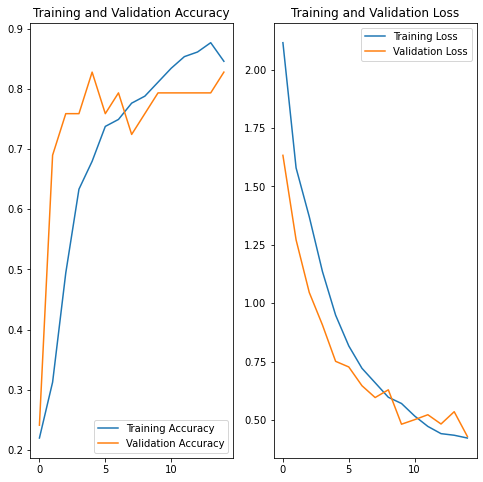

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
model.save('cnn_trained.h5')

## Test ##

In [16]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

3/3 [==============================] - 0s 3ms/step - loss: 0.4725 - accuracy: 0.8194


[0.4725106954574585, 0.8194444179534912]

In [ ]:
print(model.trainable_weights)

print("{",end="")
first = True
for val in model.trainable_weights[9].numpy():
    if first == False:
        print(",",end="")
    first = False
    print(val,end="")
print("};")

print("{")
first_3 = True
for filter in model.trainable_weights[6].numpy():
    if first_3 == False:
        print(",", end="")
    first_3 = False
    print("{",end="")
    first = True
    for row in filter:
        if first == False:
            print(",", end="")
        print("{" , end="")
        first = False
        
        first_2 = True
        for val in row:
            if first_2 == False:
                print(",", end="")
            print(val , end="")
            first_2 = False
        print("}")
    print("}")
    print()
print("};")

print("{")
first_3 = True
for filter in model.trainable_weights[8].numpy():
    if first_3 == False:
        print(",", end="")
    first_3 = False
    print("{",end="")
    first_2 = True
    for val in filter:
        if first_2 == False:
            print(",", end="")
        print(val , end="")
        first_2 = False
    print("}")
print("};")